In [33]:
#importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import yahoo_fin.stock_info as si
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import scipy.optimize as spop
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
# https://www.youtube.com/watch?v=jvZ0vuC9oJk&list=PLE4a3phdCOauXaK3f1QMI_fEIqEYTsH9I&index=3
# https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
from statsmodels.tsa.stattools import adfuller
from pykalman import KalmanFilter
from scipy import poly1d
import warnings
warnings.filterwarnings('ignore') 

AAPL
[*********************100%***********************]  1 of 1 completed
AMGN
[*********************100%***********************]  1 of 1 completed
AXP
[*********************100%***********************]  1 of 1 completed
BA
[*********************100%***********************]  1 of 1 completed
CAT
[*********************100%***********************]  1 of 1 completed
CRM
[*********************100%***********************]  1 of 1 completed
CSCO
[*********************100%***********************]  1 of 1 completed
CVX
[*********************100%***********************]  1 of 1 completed
DIS
[*********************100%***********************]  1 of 1 completed
DOW
[*********************100%***********************]  1 of 1 completed
GS
[*********************100%***********************]  1 of 1 completed
HD
[*********************100%***********************]  1 of 1 completed
HON
[*********************100%***********************]  1 of 1 completed
IBM
[*********************100%*********************

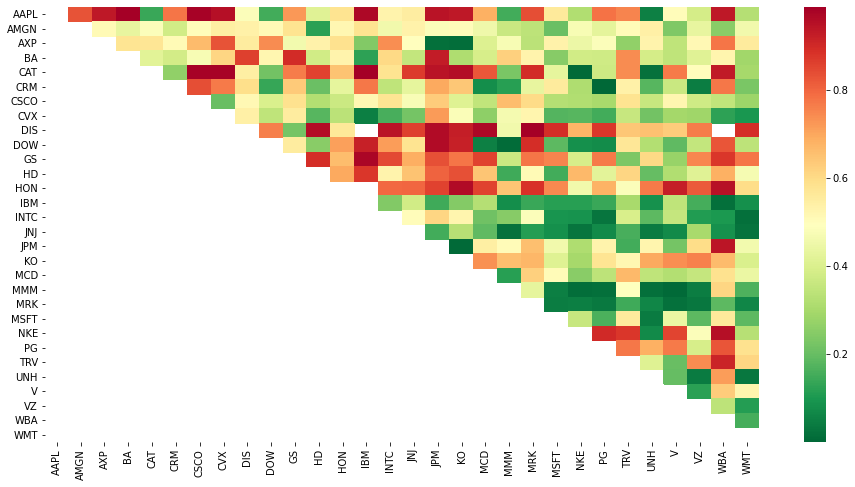

Most cointegrated pairs are: [('CAT', 'NKE'), ('CRM', 'PG'), ('DOW', 'MMM'), ('JPM', 'KO'), ('MMM', 'V')]


In [34]:
# https://github.com/Auquan/Tutorials/blob/master/Pairs%20Trading.ipynb
dow_list = si.tickers_dow()
df = pd.DataFrame()
for i in dow_list:
    print(i)
    prices = yf.download(i,'2020-01-01','2021-01-01')
    df[i] = prices['Adj Close']

def find_cointegrated_pairs(data):
    n = data.shape[1] # number of columns
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys() # index object of df columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]] # first stock
            S2 = data[keys[j]] # second stock
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(df)
plt.figure(figsize=(16,8))
seaborn.heatmap(pvalues,xticklabels=list(dow_list),yticklabels=list(dow_list),cmap='RdYlGn_r',mask =(pvalues>=0.99),)
plt.show()
print(f'Most cointegrated pairs are: {pairs}')

In [35]:
#specifying parameters
start = '2018-12-31'
end = '2021-03-08'
fee = 0.001
window = 90 # this is the rolling window

dow_list = si.tickers_dow()
for i in ['TSLA']:
    stock = i
    #retrieving data
    df = pd.DataFrame()
    returns = pd.DataFrame()
    prices = yf.download(i, start, end)
    df['price'] = prices['Adj Close']
    #df['return'] = prices['Adj Close'].pct_change().shift(-1)
    df['return'] = np.log(prices['Adj Close']).diff().shift(-1)
    # important! need to match today's price (or signal) with tomorrow's return in the same df row for backtesting
    df = df[:-1]
df

[*********************100%***********************]  1 of 1 completed


,price,return
Date,,
2018-12-31,66.559998,-0.070582
2019-01-02,62.023998,-0.031978
2019-01-03,60.071999,0.056094
2019-01-04,63.537998,0.052935
2019-01-07,66.991997,0.001164
...,...,...
2021-02-26,675.500000,0.061615
2021-03-01,718.429993,-0.045549
2021-03-02,686.440002,-0.049635


In [36]:
def fft_std_filter(std_value):
    
    # for the variables can be used outside function
    global regressionDelta
    global regression
    regressionDelta = 0
    regression = 0
    
    #Getting dominant values based on std_value
    meanAmp = amplitude.mean()
    stdAmp = amplitude.std()
    dominantAmp = list(filter(lambda x : x > (std_value*stdAmp + meanAmp),amplitude))
    dominantTheta = theta

    #Calculating Regression Delta
    for n in range(len(dominantAmp)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(window)) + shift) # adding up till len(ft)

    #Converting Delta Time to Time at start value of real data
    startValue = ft['price'][0]
    regression = startValue + np.cumsum(regressionDelta)

    #Calculating RMSE
    rmse = np.sqrt(np.mean((ft['price'].values - regression)**2))

    #if np.isnan(rmse) or len(regression)==1:
    if np.isnan(rmse):
        rmse = 10000000000000

    return rmse


In [37]:
df['fft price'] = 0

# do FFT stock price perdiction on every day
for i in range(window+2,len(df)):  ## remember to change it back to full len(df) ## need +2 as it's min for fft transform
    delta = np.array([])
    theta = np.array([])
    amplitude = np.array([])
    freq = np.array([])
    ft = pd.DataFrame([])
    print(i)
    ft = df[i-window:i].copy()
    #display(ft)
    delta = ft['price'].diff()
    delta = delta[1:]
    sp = np.fft.fft(delta.values) # fft must be done without and NaN
    theta = np.arctan(sp.imag/sp.real) # phase in polar form
    amplitude = np.sqrt(sp.real**2 + sp.imag**2)/(window/2)# we only care about positive absolute amplitude, therefore 1/2
    freq = np.fft.fftfreq(sp.size) # cycles per sample spacing
    std_values = []
    rmse_values = []
    # loop thru and try diff std filter thresholds
    for j in np.linspace(0,4,20): # 100 steps, infer step size
        std_values.append(j)
        rmse_values.append(fft_std_filter(j))
    #print(rmse_values)
    idx = np.array(rmse_values).argmin()
    minSTD = std_values[idx]
    #print('minSTD is '+str(minSTD))
    minRMSE = rmse_values[idx]
    #print('minRMSE is '+str(minRMSE))
    fft_std_filter(minSTD)
    df['fft price'][i] = regression[-1]
    #print(regression)

92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343


In [38]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 200)
pd.set_option('display.expand_frame_repr', True)
df.sort_values('return')
df

,price,return,fft price
Date,,,
2018-12-31,66.559998,-0.070582,0
2019-01-02,62.023998,-0.031978,0
2019-01-03,60.071999,0.056094,0
2019-01-04,63.537998,0.052935,0
2019-01-07,66.991997,0.001164,0
2019-01-08,67.070000,0.009438,0
2019-01-09,67.706001,0.018845,0
2019-01-10,68.994003,0.006616,0
2019-01-11,69.452003,-0.037736,0


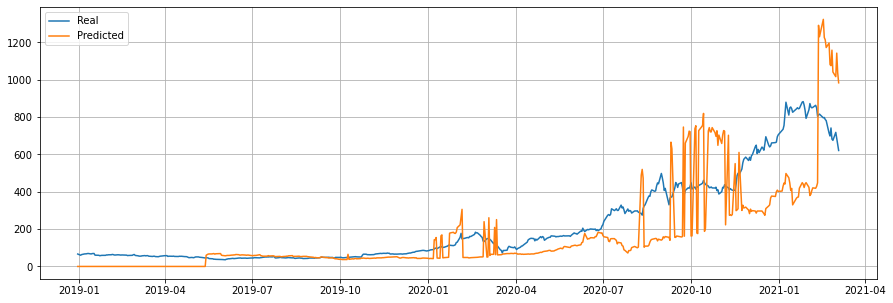

In [39]:
plt.figure(figsize=(15,5))
plt.plot(df['price'])
plt.plot(df['fft price'])
#plt.plot(df[df['fft price']>150])
plt.legend(['Real','Predicted'])
plt.grid()


In [40]:
# Construct a Kalman filter
df['kf price'] = 0.0

kf = KalmanFilter(observation_matrices = [1], # this tells us the next measurement we should expect given the predicted next state
                  # or this can be random walk if modeling a fairly stable system so next move would be the same 1*
                  # observation matrix will dot with transition matrix
                  observation_covariance=1, # assume price has variance 1 under R.W model (hard to know)
                  # also this represents the error of the guesses
                  initial_state_mean = 0, # guess 0 for 1d
                  initial_state_covariance = 1, # assume price move as our model says, 1 for identity matrix. error for guess
                  transition_matrices = [1], # how state evolves (identity matrix if R.W)
                  transition_covariance=.01)# this is the kalman gain or err term for transition matrix: 
                  # (Err_state)/(Err_state+Err_measure)
                  # important to keep track this as new measurements come in, also hard to know
                  # bigger this value, more overfitting
                  # close to 1 means stock price is accurate - weigh more on recent event
                  # close to 0 means stock price is not accurate - weigh more on historical event

for i in range(window+2,len(df)): 
    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(df['fft price'][:i]) # ignore cov so repalce with _
    df['kf price'][i] = state_means[-1]

df

,price,return,fft price,kf price
Date,,,,
2018-12-31,66.559998,-0.070582,0,0.000000
2019-01-02,62.023998,-0.031978,0,0.000000
2019-01-03,60.071999,0.056094,0,0.000000
2019-01-04,63.537998,0.052935,0,0.000000
2019-01-07,66.991997,0.001164,0,0.000000
2019-01-08,67.070000,0.009438,0,0.000000
2019-01-09,67.706001,0.018845,0,0.000000
2019-01-10,68.994003,0.006616,0,0.000000
2019-01-11,69.452003,-0.037736,0,0.000000


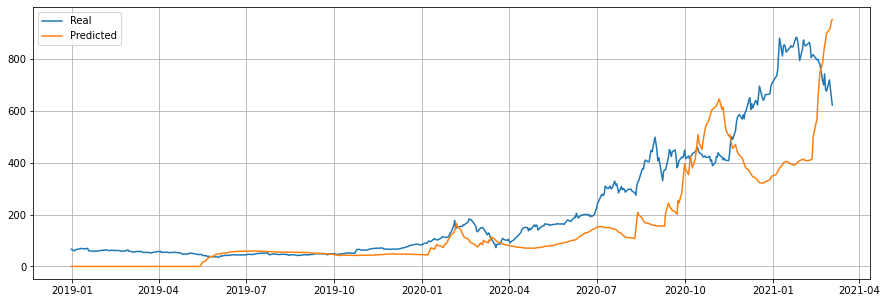

In [41]:
plt.figure(figsize=(15,5))
plt.plot(df['price'])
plt.plot(df['kf price'])
#plt.plot(df[df['fft price']>150])
plt.legend(['Real','Predicted'])
plt.grid()

beta is 1.2261157419937962
ADF Statistic: -4.665482482126512
n_lags: 9.765664871807112e-05
p-value: 9.765664871807112e-05
Critial Values:
   1%, -3.442701754304053
Critial Values:
   5%, -2.866988120523906
Critial Values:
   10%, -2.5696716542766693


-3.052212655535094

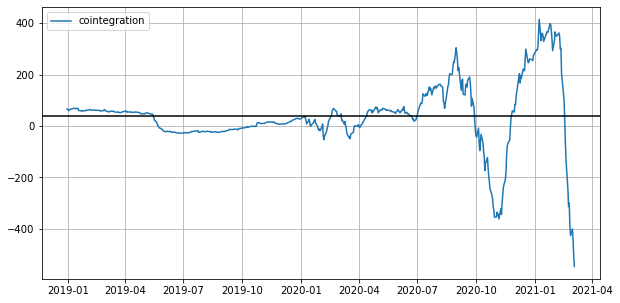

In [42]:
### just for displaying

# this is for overall period
X = sm.add_constant(df['kf price'])
results = sm.OLS(df['price'],df['kf price']).fit()
beta = results.params['kf price']
print(f'beta is {beta}')
df['cointegration'] = df['price'] - beta * df['kf price'] # this is the noise should be mean reverting, spread is scaled by beta rather than simple difference

plt.figure(figsize=(10,5))
plt.plot(df['cointegration'])
plt.grid()
plt.legend(['cointegration'])
plt.axhline(df['cointegration'].mean(),color='black')

result = adfuller(df['cointegration'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html    
a = coint(beta*df['kf price'],df['price']) #Augmented Engle-Granger two-step cointegration test
a[2][2]



In [43]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

df['net_return'] = 0.0
df['long signal'] = 0

for i in range(window+2,len(df)):  ## remember to change it back to full len(df)
    sample = df.iloc[i-window:i,:]
    X = sm.add_constant(sample['kf price'])
    results = sm.OLS(sample['price'],sample['kf price']).fit()
    beta = results.params['kf price']
    #print(f'beta is {beta}')
    sample['cointegration'] = sample['price'] - beta * sample['kf price'] 
    # this is the noise should be mean reverting, spread is scaled by beta rather than simple difference
    result = adfuller(sample['cointegration'], autolag='AIC')
    result2 = coint(beta*df['kf price'],df['price'])
    
    if i == window+2: # starting point
        old_signal = 0
    if result[0] > result[4]['10%'] or result2[0] > result2[2][2]: # nothing happens
        signal = 0
        df['net_return'].iloc[i,:] = 0
    elif result[0] < result[4]['10%'] and \
    (sample['cointegration'][-1]-sample['cointegration'].mean())/sample['cointegration'].std()>1 and \
    result2[0] < result2[2][2]:
        # trigger trading signal when test statistic is more negative for Augmanted Dickey Fuller unit roo test
        # based on time series diff beta stationarity. More negative means more likey to reject unit root exists which make nonstatioanry
        # from dickey and fuller unit root test, more negative is better
        # trigger trading signal when test statistic is more negative for Engle-Granger test (based on residual stationarity)
        # trigger signal when cointegration spread zscore above 1 std
        signal = np.sign(df['price'][i] - df['fft price'][i]) # if - then long the stock, as undervalued
        df['long signal'].iloc[i,:] = -signal
        gross_return = -signal*df['return'][i]
        fees = fee*abs(signal - old_signal)
        net_return = gross_return - fees
        df['net_return'].iloc[i,:] = net_return
    old_signal = signal

df['open long'] = df['long signal'].diff()
df[window+2-1:] # start looking from the day before first strategy trigger

,price,return,fft price,kf price,cointegration,net_return,long signal,open long
Date,,,,,,,,
2019-05-13,45.402000,0.023079,0,0.000000,45.402000,0.0,0,0.0
2019-05-14,46.462002,-0.001551,60,0.000000,46.462002,0.0,0,0.0
2019-05-15,46.389999,-0.015730,63,5.707495,41.568876,0.0,0,0.0
2019-05-16,45.666000,-0.078792,66,11.157440,36.237112,0.0,0,0.0
2019-05-17,42.206001,-0.027236,67,16.374335,28.383807,0.0,0,0.0
2019-05-20,41.071999,-0.001364,67,21.190097,23.203655,0.0,0,0.0
2019-05-21,41.015999,-0.062110,68,25.547761,19.483055,0.0,0,0.0
2019-05-22,38.546001,0.014219,69,29.586027,13.619576,0.0,0,0.0
2019-05-23,39.098000,-0.025175,66,33.335278,11.011219,0.0,0,0.0


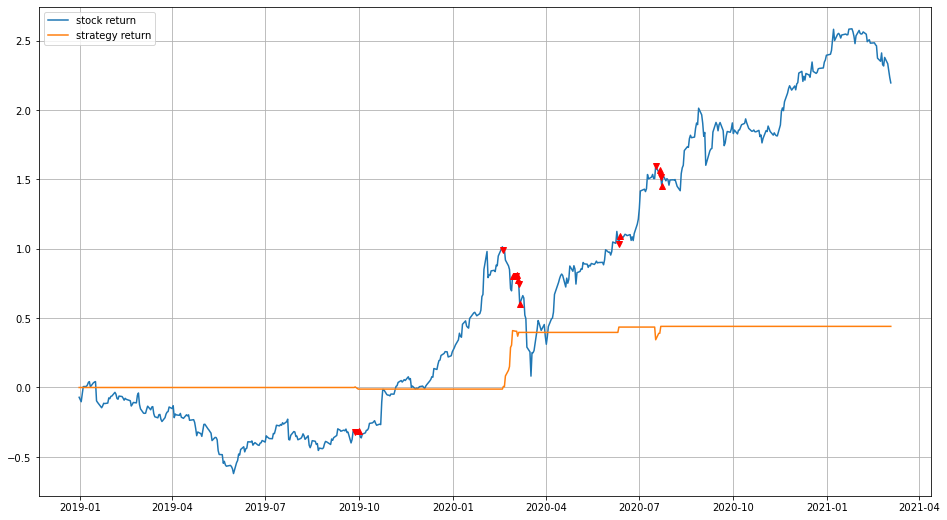

In [44]:
plt.figure(figsize=(16,9))
# since not using log return initially, so have to use (1+r1)*(1+r2)
plt.plot(df['return'].cumsum())
plt.plot(df['net_return'].cumsum())
plt.legend(['stock return','strategy return'])
plt.grid()
for i in range(0,len(df)):
    if df['open long'][i] > 0:
        plt.plot(df.index[i],df['return'].cumsum()[i],'r^')
    if df['open long'][i] < 0:
        plt.plot(df.index[i],df['return'].cumsum()[i],'rv')


In [45]:
print(f'Final result for stock {stock}')
if df["net_return"].cumsum()[-1] > 0:
    print(f'Annualized return: {round(np.power(df["net_return"].cumsum()[-1]*100,360/len(df[window+2:])),2)}%')
    print(f'Annualized Sharpe ratio: {round(np.power(df["net_return"].mean()/df["net_return"].std(),360/len(df[window+2:])),2)}')
else:
    print(f'Annualized return: {round(df["net_return"].cumsum()[-1]*100,2)}%')
    print(f'Annualized Sharpe ratio: {round((df["net_return"].mean()/df["net_return"].std()),2)}')
print(f'Max drawdown: {round(df["net_return"].cumsum().min()*100,4)}%')
print(f'Number of trades generated annually: {int(np.power(np.count_nonzero(df["open long"]!=0),360/len(df[window+2:])))}')

Final result for stock TSLA
Annualized return: 19.86%
Annualized Sharpe ratio: 0.14
Max drawdown: -1.1517%
Number of trades generated annually: 8


In [46]:
df

,price,return,fft price,kf price,cointegration,net_return,long signal,open long
Date,,,,,,,,
2018-12-31,66.559998,-0.070582,0,0.000000,66.559998,0.0,0,NaN
2019-01-02,62.023998,-0.031978,0,0.000000,62.023998,0.0,0,0.0
2019-01-03,60.071999,0.056094,0,0.000000,60.071999,0.0,0,0.0
2019-01-04,63.537998,0.052935,0,0.000000,63.537998,0.0,0,0.0
2019-01-07,66.991997,0.001164,0,0.000000,66.991997,0.0,0,0.0
2019-01-08,67.070000,0.009438,0,0.000000,67.070000,0.0,0,0.0
2019-01-09,67.706001,0.018845,0,0.000000,67.706001,0.0,0,0.0
2019-01-10,68.994003,0.006616,0,0.000000,68.994003,0.0,0,0.0
2019-01-11,69.452003,-0.037736,0,0.000000,69.452003,0.0,0,0.0
